<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/TF_ObjDet_SSD_MobNet/Car_BBOX_Det_SSD_Mob_Net_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Bounding Box Detection - SSD MobileNet Detector - Inference NB


# Copy model and complete other preliminaries

## Connect to Google Drive

In [1]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


## Copy required files

In [2]:
%%capture

# Copy dataset from Google Drive
!cp /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Datasets/Image_Datasets/Stanford_Car_Dataset/Consolidated_Dataset.zip .
# Unzip dataset file
!unzip Consolidated_Dataset.zip
# Delete zip file
!rm Consolidated_Dataset.zip

## Copy model and label class mapping from Google Drive

In [3]:
# Copy model directory
!cp -r /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model/Trained_Models/M1/detection_model .
# Copy label-class mapping pkl file
!cp /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Car_BBOX_SSD_MobNet_Model/Trained_Models/M1/car_dataset_label.pkl .

## Import required libraries

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import datetime
import pytz
import time
import os
import cv2

import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

## Extract label_class_dict from pkl file

In [5]:
# Pickle file where index to label mapping is stored
fname = "/content/car_dataset_label.pkl" 
with open(fname, "rb") as file:
    label_class_dict = pickle.load(file)
    
print(f"Type of label_class_dict is {type(label_class_dict)}")
print()
print(f"Keys of label_class_dict are:")
print("--------------------------------")
print(label_class_dict.keys())
print()
print("First five elements of label_class_dict are:")
print("-----------------------------------------------")
for ind in range(1, 6, 1):
    print(label_class_dict[ind])

Type of label_class_dict is <class 'dict'>

Keys of label_class_dict are:
--------------------------------
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196])

First fi

## Load saved model

In [6]:
%%capture
# Define path where model is stored
model_path = '/content/detection_model/saved_model'
# Load model from path
model = tf.saved_model.load(model_path)

## Create train_df and test_df

In [7]:
# Load train annotation file in a DataFrame
ann_train_csv_path = '/content/annot_train_cons.csv'
train_df = pd.read_csv(ann_train_csv_path)
display(train_df.head())

,filename,xmin,ymin,xmax,ymax,label,img_h,img_w,class
0,00001.jpg,39,116,569,375,14,400.0,600.0,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,675.0,900.0,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,480.0,640.0,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,1386.0,2100.0,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,108.0,144.0,Ford F-450 Super Duty Crew Cab 2012


In [8]:
# Load test annotation file in a DataFrame
ann_test_csv_path = '/content/annot_test_cons.csv'
test_df = pd.read_csv(ann_test_csv_path)
display(test_df.head())

,filename,xmin,ymin,xmax,ymax,label,img_h,img_w,class
0,00001.jpg,30,52,246,147,181,182.0,276.0,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,103,360.0,640.0,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,145,741.0,1024.0,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,187,480.0,640.0,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,185,373.0,600.0,Tesla Model S Sedan 2012


In [9]:
# Get dataset size
print("Number of images in training set is %d" %train_df.shape[0])
print("Number of images in test set is %d" %test_df.shape[0])

Number of images in training set is 8144
Number of images in test set is 8041


# Make predictions

## Function: predict_and_plot

In [10]:
def predict_and_plot(df, samp_indices, img_root_path, model, num_cols, col_size, row_size, fig_title,\
                     box_thickness):

  '''
  Function to make predictions on a subset of data and plot images with actual
  and predicted labels

  Arguments:
    X: Input image array
    y: Input label array
    samp_indices: Indices from X to be plotted
    model: Model instance to use for making predictions
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting
    fig_title: Title to use for overall figure
  ''' 

  num_rows = math.ceil(len(samp_indices) / num_cols) # Number of rows to use for plotting
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(fig_title, fontsize = 40)

  for ind, samp_ind in enumerate(samp_indices): # Loop through samp_indices
    img_file_name = df.loc[samp_ind, 'filename'] # Extract image filename from DataFrame
    img_file_path = os.path.join(img_root_path, img_file_name) # Obtain image file path
    img = cv2.cvtColor(cv2.imread(img_file_path), cv2.COLOR_BGR2RGB) # Load image
    img_mod = np.expand_dims(img, axis = 0) # Add batch axis to feed to model
    model_out = model(img_mod) # Pass input image through model

    xmin, ymin, xmax, ymax = df.loc[samp_ind, ['xmin', 'ymin', 'xmax', 'ymax']] # Get ground-truth 
                                                                                # BBOX co-ords
    img_h, img_w = df.loc[samp_ind, ['img_h', 'img_w']] # Extract image dimensions
    act_class = df.loc[samp_ind, 'class'] # Get ground-truth class

    score = 100 * model_out['detection_scores'][0].numpy()[0] # Extract best box score
    bbox = model_out['detection_boxes'][0].numpy()[0] # Extract BBOX co-ordinates
    label = model_out['detection_classes'][0].numpy().astype('int32')[0] # Extract class index
    pred_class = label_class_dict[label] # Obtain class of car

    # Scale BBOX co-ordinates to image dimensions
    (bbox_ymin, bbox_xmin, bbox_ymax, bbox_xmax) = (int(bbox[0] * img_h), int(bbox[1] * img_w),\
                                                    int(bbox[2] * img_h), int(bbox[3] * img_w))  
    
    # Draw ground-truth BBOX in green
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), box_thickness)
    # Draw predicted BBOX in blue    
    cv2.rectangle(img, (bbox_xmin, bbox_ymin), (bbox_xmax, bbox_ymax), (0, 0, 255), box_thickness)

    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    ax.text(0, -40, f"Actual class: {act_class}", fontsize = 'xx-large')
    ax.text(0, -10, f"Predicted class: {pred_class} ({score:0.2f}%)", fontsize = 'xx-large')
    ax.imshow(img) 

## Training Set Predictions

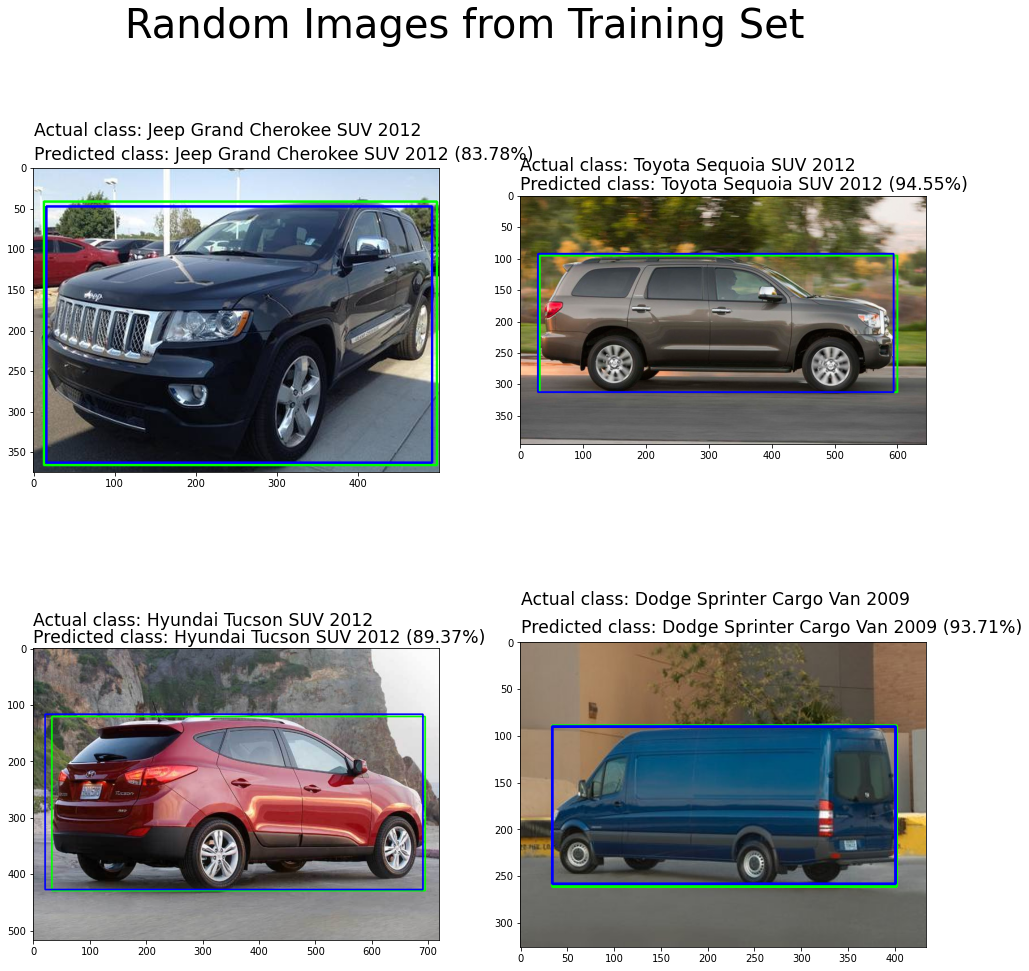

In [11]:
img_root_path = "/content/train_images"
fig_title = 'Random Images from Training Set'
samp_indices = list(np.random.randint(low = 0, high = train_df.shape[0], size = 4))

predict_and_plot(train_df, samp_indices, img_root_path, model, 2, 8, 8, fig_title, 2)

## Test Set Predictions

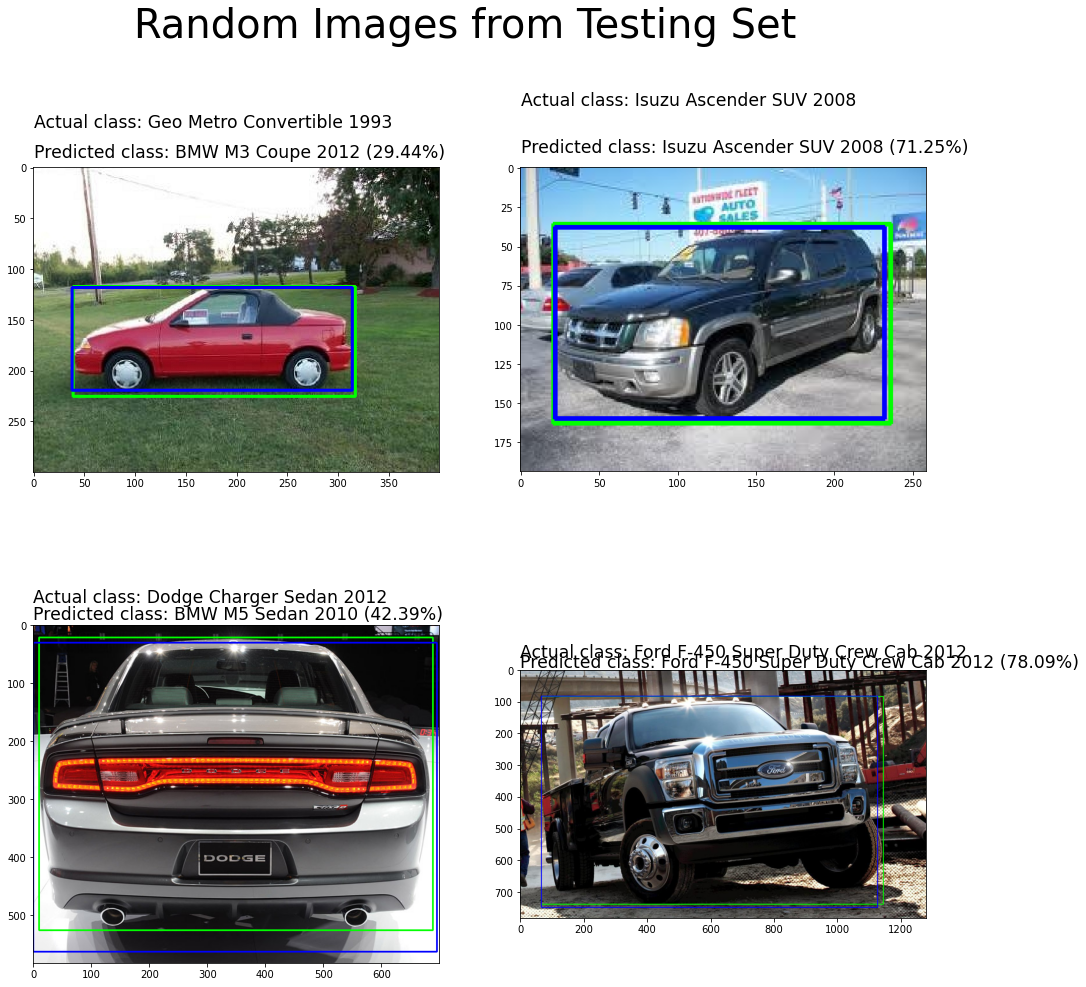

In [12]:
img_root_path = "/content/test_images"
fig_title = 'Random Images from Testing Set'
samp_indices = list(np.random.randint(low = 0, high = test_df.shape[0], size = 4))
predict_and_plot(test_df, samp_indices, img_root_path, model, 2, 8, 8, fig_title, 2)